In [1]:
from data_generation import *

import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,concat_ws, collect_list, lit,split, size, avg, udf
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.types import StructType, StructField, IntegerType, StringType


from datasketch import MinHash, MinHashLSH
from sklearn.cluster import KMeans
from numpy import average
import numpy as np 

import shutil
import os
import numpy as np

import time
import resource
import psutil
import matplotlib.pyplot as plt
#import pandas as pd


# All functions used

In [11]:
################################################################################################################################
################################################# Question 1 ###################################################################
################################################################################################################################

def shingle(text, k=7):
    shingle_set = []
    for i in range(len(text)-k +1):
        shingle_set.append(text[i:i+k])
    return list(set(shingle_set))

def jaccard_similarity(list1, list2):   
    return len(set(list1).intersection(set(list2))) / len(set(list1).union(set(list2)))

def minhash_lsh(df, k_shingle, threshold):

    lsh = MinHashLSH(threshold=threshold, num_perm=128)
    minhashes = {}

    for features in df.collect():
        shingles = shingle(features["features"], k_shingle)
        m = MinHash(num_perm=128)
        for shingle_item in shingles:
            m.update(shingle_item.encode("utf8"))
        minhashes[int(features["user_id"])] = m
        lsh.insert(int(features["user_id"]), m)

    replacement_candidates = {}
    for key in lsh.keys: 
        replacement_candidates[key] = lsh.query(minhashes[key]) 

    #Key: New representative, value: Similar items
    return replacement_candidates,minhashes

#Iteratively bucket unique processes together
def bucketing(replacement_candidates):
    visited_processes = set()
    new_process_dictionary = {}
    for key, values in replacement_candidates.items():
        new_values = []
        for value in values:
            if value not in visited_processes:
                visited_processes.add(value)
                new_values.append(value)
        if new_values:  # Only add non-empty lists
            new_process_dictionary[key] = sorted(new_values)
    return new_process_dictionary

def get_memory_usage(): 
    return resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024

def get_cpu_usage(): 
    return psutil.cpu_percent(interval=None)

def get_performance(func1,func2, vals):
    #k_values = [2, 3, 4, 5, 6, 7, 8]
    results = []

    for k in vals:
        start_time = time.time()
        start_mem = get_memory_usage()
        start_cpu = get_cpu_usage()

        replacement_candidates, minhashes = func1(df_grouped, k, 0.98)
        new_process_dictionary = func2(replacement_candidates)
        
        end_time = time.time()
        end_mem = get_memory_usage()
        end_cpu = get_cpu_usage()

        duration = end_time - start_time
        mem_used = end_mem - start_mem

        results.append({
            'k': k,
            'time_seconds': duration,
            'memory_mb': mem_used,
            'unique_processes': len(new_process_dictionary),
            'cpu': end_cpu
        })
    return results

def plot_results(results):
    k_values = [result['k'] for result in results]
    time_seconds = [result['time_seconds'] for result in results]
    cpu_percentages = [result['cpu'] for result in results]
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.set_xlabel('k values')
    ax1.set_ylabel('Time (seconds)', color='tab:blue')
    ax1.plot(k_values, time_seconds, marker='o', color='tab:blue', label='Time')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('CPU Usage (%)', color='tab:red')

    ax2.plot(k_values, cpu_percentages, marker='^', color='tab:red', linestyle='--', label='CPU Usage')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title('Performance Metrics for Different k Values')
    fig.legend(loc='upper left')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

def plot_performances(results, include_unique_processes=True):
    k_values = [result['k'] for result in results]
    time_seconds = [result['time_seconds'] for result in results]
    cpu_percentages = [result['cpu'] for result in results]

    performance_metric = [time_seconds[i] * cpu_percentages[i] for i in range(len(results))]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(k_values, performance_metric, marker='o', linestyle='-', color='purple', label='Time * CPU')
    ax1.set_xlabel('k values')
    ax1.set_ylabel('Performance Metric (Time * CPU)', color='purple')
    ax1.tick_params(axis='y', labelcolor='purple')

    if include_unique_processes:
        unique_processes = [result['unique_processes'] for result in results]

        ax2 = ax1.twinx()
        ax2.set_ylabel('Unique Processes', color='green')
        ax2.plot(k_values, unique_processes, marker='s', linestyle='--', color='green', label='Unique Processes')
        ax2.tick_params(axis='y', labelcolor='green')

    plt.title('Combined Metric of Time and CPU Usage vs. k Values' +
              (' with Unique Processes' if include_unique_processes else ''))
    fig.legend(loc='upper left')

    plt.tight_layout()
    plt.grid(True)
    plt.show()

def get_case(caseID,data):
    data1 = data.filter(data.user_id.isin([caseID]))
    data1.show()

def compare_cases(case1,case2,data):
    data1 = data.filter(data.user_id.isin([case1]))
    data2 = data.filter(data.user_id.isin([case2]))
    desired_column_list1 = data1.select("to").rdd.flatMap(lambda x: x).collect()
    desired_column_list2 = data2.select("to").rdd.flatMap(lambda x: x).collect()

    common_elements = np.intersect1d(desired_column_list1, desired_column_list2)
    union_elements = np.union1d(desired_column_list1, desired_column_list2)
    print(len(common_elements)/len(union_elements))

def get_traces(user_id,df =df_grouped):
    result = df.filter(col("user_id") == user_id).select("features").collect()
    if result:
        return result[0]["features"]
    else:
        return None

def get_shingles(user_id,df = df_shingles):
    result = df.filter(col("user_id") == user_id).select("shingles").collect()
    if result:
        return result[0]["shingles"]
    else:
        return None


def write_df(df,file_name):
    os.makedirs('Output', exist_ok=True)
    os.makedirs('temp', exist_ok=True)
    df.write.csv('temp/temp_outoput', header=True, mode="overwrite")
    part_file = [f for f in os.listdir('temp/temp_outoput') if f.startswith("part-")][0]

    shutil.move(os.path.join('temp/temp_outoput', part_file), file_name)
    shutil.rmtree('temp/temp_outoput')
    shutil.rmtree('temp')

def output_part1(dataset,k,threshold):
    data = spark.read.csv(dataset, header=True, inferSchema=True)
    df = data.withColumn("arrayColumn", concat_ws("","from", "to")).withColumn("Minhash", lit(""))
    df_grouped = df.groupBy("user_id").agg(
                                            concat_ws("",collect_list("arrayColumn")).alias("features"))
    
    replacement_candidates = minhash_lsh(df_grouped,k,threshold)
    new_process_dictionary = bucketing(replacement_candidates)    

    user_ids = list(new_process_dictionary.keys())
    max_user_id = max(user_ids)
    output_df = data.filter(df.user_id.isin(user_ids))
    final_df = output_df.coalesce(1)
    return write_df(final_df,'Output/part1Output.csv')


################################################################################################################################
################################################# Question 2 ###################################################################
################################################################################################################################

def kmeans_clustering(df, n_clusters, max_iter):
    minhashes = []
    #for jaccard verification
    minhash_dict = {}
    user_ids = []
    final_buckets = {}
    for features in df.collect():
        shingles = shingle(features["features"], 5)
        m = MinHash(num_perm=128)
        for shingle_item in shingles:
            m.update(shingle_item.encode("utf8"))
        minhashes.append(m.hashvalues)
        minhash_dict[int(features["user_id"])] = m
        user_ids.append(int(features["user_id"]))

    kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter).fit(minhashes)

    user_clusters = dict(zip(user_ids, kmeans.labels_))
    final_buckets = {}
    for key, value in user_clusters.items():
        if value in final_buckets:
            final_buckets[value].append(key)
        else:
            final_buckets[value] = [key]

    return final_buckets, minhash_dict

def get_averege_jaccard_sim(final_buckets, minhashes,get = True):
    sims = {}
    for key, value in final_buckets.items():
        for user_id_1 in final_buckets[key]:
            for user_id_2 in final_buckets[key]:
                if user_id_1 != user_id_2:
                    sig_1 = minhashes[int(user_id_1)]
                    sig_2 = minhashes[int(user_id_2)]
                    sim = MinHash.jaccard(sig_1, sig_2)
                    if key not in sims:
                        sims[key] = [sim]
                    else:
                        sims[key].append(sim)
    total_sum = 0
    total_count = 0
    sims = dict(sorted(sims.items()))
    if get == True:
        for key, value in sims.items():
            avg_sim = average(value)
            print(key, avg_sim)
            total_sum += sum(value)
            total_count += len(value)
        
        overall_average = total_sum / total_count if total_count != 0 else 0
        print("Overall Average Jaccard Similarity:", overall_average)

    return sims


NameError: name 'df_shingles' is not defined

# Experiments

In [2]:
spark = SparkSession.builder.getOrCreate()

data = spark.read.csv("data/SDG_dataset2.csv", header=True, inferSchema=True)
df_filtered_m = data.filter(data.type.isin(['Req']))
df_grouped = df_filtered_m.groupBy("user_id").agg(concat_ws("",collect_list("to")).alias("features"))
#data.show()
#df_filtered_m.show()
#df_grouped.show()

24/06/25 00:18:31 WARN Utils: Your hostname, MacBook-Air-de-Hugo-2.local resolves to a loopback address: 127.0.0.1; using 192.168.0.109 instead (on interface en0)
24/06/25 00:18:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/25 00:18:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Question 1

### Paramter-tuning for k-shingles

First we're going to see which k is the best for the k-shingles. We gonna do such a thing by investigating how computational expensive it is to compute such minhash for different values of k

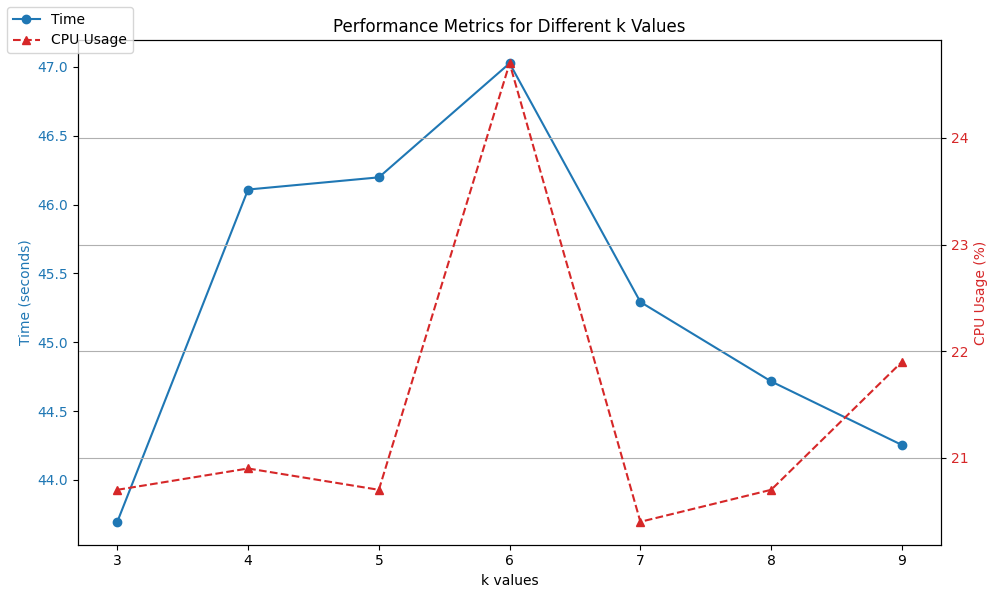

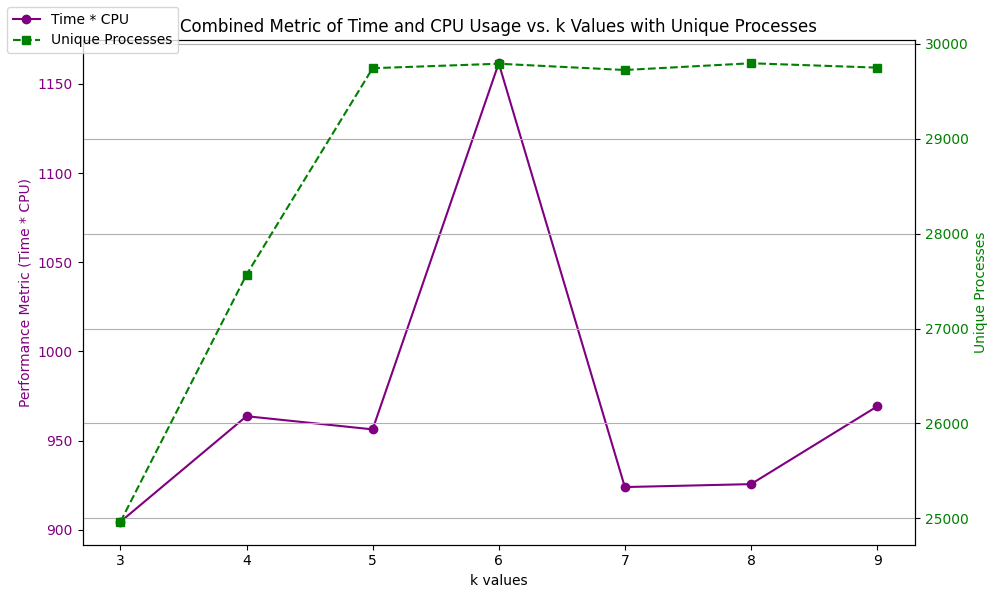

In [13]:
results = get_performance(minhash_lsh,bucketing, [3,4,5,6,7,8,9])
plot_results(results)
plot_performances(results)

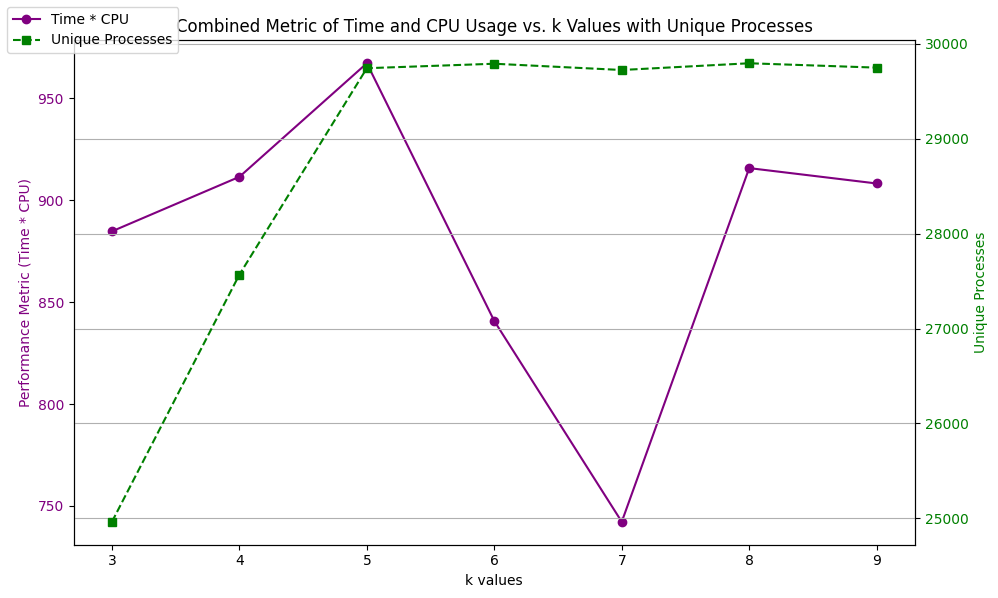

In [10]:
def plot_performances_with_unique_processes(results):
    k_values = [result['k'] for result in results]
    time_seconds = [result['time_seconds'] for result in results]
    cpu_percentages = [result['cpu'] for result in results]
    unique_processes = [result['unique_processes'] for result in results]

    performance_metric = [time_seconds[i] * cpu_percentages[i] for i in range(len(results))]
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(k_values, performance_metric, marker='o', linestyle='-', color='purple', label='Time * CPU')
    ax1.set_xlabel('k values')
    ax1.set_ylabel('Performance Metric (Time * CPU)', color='purple')
    ax1.tick_params(axis='y', labelcolor='purple')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Unique Processes', color='green')
    ax2.plot(k_values, unique_processes, marker='s', linestyle='--', color='green', label='Unique Processes')
    ax2.tick_params(axis='y', labelcolor='green')

    plt.title('Combined Metric of Time and CPU Usage vs. k Values with Unique Processes')
    fig.legend(loc='upper left')

    plt.tight_layout()
    plt.grid(True)
    plt.show()

plot_performances_with_unique_processes(results)

By running this a considerable amount of times we saw that the value that get a better balance between time and CPU usage is when k=7.

### Parameter-tuning for the threshold

In [5]:
shingles_udf = udf(shingle, ArrayType(StringType()))

df_shingles = df_filtered_m.groupBy("user_id").agg(concat_ws("", collect_list("to")).alias("trace")) \
    .withColumn("shingles", shingles_udf(col("trace"))) \
    .select("user_id", "shingles")
#df_shingles.show()
average_num_shingles = df_shingles.withColumn("list_length", size(col("shingles"))) \
                     .agg(avg("list_length").alias("average_list_length")).collect()[0][0]
average_num_shingles
#spark.stop()

+-------+--------------------+
|user_id|            shingles|
+-------+--------------------+
|      1|[_3S5S5_, 1S4S4_3...|
|     12|[2S2_4S2, S1_1S2S...|
|     22|[_3S2_5S, S1_1S2S...|
|     26|[S5S5_2S, S5_2S5_...|
|     27|[S2_2S1S, S5_1S5_...|
|     28|[S5S5_2S, S4S4_4S...|
|     31|[1_2S2S2, S0S4S4_...|
|     34|[_2S5S5_, S5S5_2S...|
|     44|[_3S5S5_, S5_1S5_...|
|     47|[S5S5_2S, _2S3S3_...|
|     52|[S5S5_2S, _3S2_2S...|
|     53|[S5_1S5_, 5_1S5_1...|
|     65|[S3S3_1S, _1S3_2S...|
|     76|[_3S5S5_, S5S5_2S...|
|     78|[_3S5S5_, S5_1S5_...|
|     81|[_3S5S5_, S5_1S5_...|
|     85|[_3S5S5_, S5S5_2S...|
|     91|[_3S5S5_, 2S2_4S2...|
|     93|[2S2_4S2, S1_1S2S...|
|    101|[S5S5_2S, _5S5S5_...|
+-------+--------------------+
only showing top 20 rows



32.36436335225314

Given that the average number of 7-shingles is 32, and we want to group processes with only small variations, we want that 31/32 shingles to be the same, so that we still allow for some small variations.

In [6]:
print(f"Initial number of cases: {df_grouped.count()}")
ans = minhash_lsh(df_grouped,7,0.97)
replacement_candidates7, minhash_dic = ans[0],ans[1]
new_process_dictionary7= bucketing(replacement_candidates7)
print(f"Number of unique processes after merging them with 0.97 threshold using 7-shingles: {len(new_process_dictionary7)}")

Initial number of cases: 43517


Number of unique processes after merging them with 0.97 threshold using 7-shingles: 29729


After merging the processes with a threshold of 97%, using 7-shingles, we obtain 29729 candidate unique cases. In order to investigate if further analysis into the similarities needs to be done, to make sure that the false positives do not result in cases where the cases are not small variations of each other, we are going to compute the average similarities of all buckets and investigate the mininum

In [7]:
sims = get_averege_jaccard_sim(replacement_candidates7, minhash_dic,get=False)

It's important to mention that we're still just computing the approximate jaccard similarities provided by MinHashLSH, so, in order to investigate the cases that have the smallest approximate jaccard similarities, we're going to compute the actual similarities between those cases

In [8]:
ans = min(set(value for key,values in sims.items() for value in values if value != 1.0))
final_values = []
for key,values in sims.items():
    for value in values:
        if value == ans:
            final_values.append(key)

dissimilar = set(final_values)

In [23]:
new_sims = []
for key in dissimilar:
    for value in replacement_candidates7[key]:
        new_sims.append((key,value,jaccard_similarity(get_shingles(value),get_shingles(key))))
investigate = [case for case in new_sims if case[-1]!=1.0]

In [24]:
for case in investigate:
    print(get_traces(case[0]))
    print(get_traces(case[1]))
    print('#####################################################################')

S0S4S4_1S3S3_1S3_2S3_3S2S2_2
S0S4S4_1S3S3_1S3_2S3_3S2S2_4
#####################################################################
S0S4S4_1S3S3_1S3_2S3_3S2S2_2
S0S4S4_1S3S3_1S3_2S3_3S2S2_4
#####################################################################
S0S4S4_1S3S3_1S3_2S3_3S2S2_4
S0S4S4_1S3S3_1S3_2S3_3S2S2_2
#####################################################################
S0S4S4_1S3S3_1S3_2S3_3S2S2_4
S0S4S4_1S3S3_1S3_2S3_3S2S2_2
#####################################################################
S0S4S4_1S3S3_1S3_2S3_3S2S2_4
S0S4S4_1S3S3_1S3_2S3_3S2S2_2
#####################################################################
S0S4S4_1S3S3_1S3_2S3_3S2S2_2
S0S4S4_1S3S3_1S3_2S3_3S2S2_4
#####################################################################


In [ ]:
# output_part1("data/SDG_dataset2.csv",3,0.95)
# output_part1("data/SDG_dataset2.csv",5,0.95)
output_part1("data/SDG_dataset2.csv",7,0.97)

## Question 2

### Parameter tuning for Kmeans

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

minhashes = []
user_ids = []
final_buckets = {}
for features in df_grouped.collect():
    shingles = shingle(features["features"], 5)
    m = MinHash(num_perm=128)
    for shingle_item in shingles:
        m.update(shingle_item.encode("utf8"))
    minhashes.append(m.hashvalues)
    user_ids.append(int(features["user_id"]))

param_grid = {
    'n_clusters': [100, 250, 500],
    'max_iter': [100, 500, 1000],
}

kmeans = KMeans()

grid_search = GridSearchCV(kmeans, param_grid, cv=5)

grid_search.fit(minhashes)

best_param = grid_search.best_params_
best_model = grid_search.best_estimator_

print("The best parameters are: " , best_param )
print("The best model is: ", best_model)

### Step 1: Find and merge

In [ ]:
replacement_candidates = minhash_lsh(df_grouped,5,0.7)
new_process_dictionary = bucketing(replacement_candidates)
print(len(replacement_candidates))
print(len(new_process_dictionary))

### STEP 2: Find/cluster similar items

In [ ]:
#from sklearn.model_selection import train_test_split, GridSearchCV

users = []
for key in new_process_dictionary:
    users.append(key)

filtered_df = df_grouped[df_grouped['user_id'].isin(users)]

final_buckets, minhashes = kmeans_clustering(filtered_df,500,100)

### Verification

In [ ]:
get_averege_jaccard_sim(final_buckets, minhashes)


# Old

In [ ]:
#print(f"Initial number of cases: {df_grouped.count()}")
# replacement_candidates3 = minhash_lsh(df_grouped,3,0.98)
# new_process_dictionary3 = bucketing(replacement_candidates3)
#print(f"After merging cases with threshold 3-shingles: {len(new_process_dictionary3)}")

In [ ]:
# df_split = df_grouped.withColumn("feature_length", size(split(col("features"), "S")))
# average_length = df_split.agg(avg("feature_length")).collect()[0][0]

# windowSpec = Window.partitionBy(F.lit(1)).orderBy("feature_length")
# df_split = df_split.withColumn("row_number", F.row_number().over(windowSpec))
# total_count = df_split.count()

# if total_count % 2 == 0:
#     median_index1 = total_count // 2
#     median_index2 = median_index1 + 1
#     median_value = df_split.filter(col("row_number").isin([median_index1, median_index2])) \
#                                   .agg(avg("feature_length")).collect()[0][0]
# else:
#     median_index = (total_count // 2) + 1
#     median_value = df_split.filter(col("row_number") == median_index) \
#                                   .select("feature_length").collect()[0][0]
    
# print(f"Average number of requests: {average_length}")
# print(f"Median number of requests: {median_value}")


#Given that both the average and the median are close to 13, which shows that the dataset is symetricly distributed when it comes to how many 
#requests are performed, we gonna assume that two cases have a small variation iif the number of different requests is around 1. To get an 
# #approximation of the threshold, we're going to use the resutls shown before, so we assume that 12/13 are the same. Given this, we decided 
# to use a threshold of 95%